# Hackernews

Demonstração com dados públicos do site Hackernews

## Pacotes

In [1]:
%matplotlib inline

from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = [15, 7]

## Carregando Dados

<div style="text-align:justify">
Dados públicos do BigQuery
</div>

In [2]:
spark = SparkSession.builder.appName('Hackernews').getOrCreate()
data = spark.read.csv('gs://data-fest-proc/zones/transient_zone/hackernews-*.csv', header=True).cache()

In [3]:
data = data.withColumn('year', year('timestamp'))
data = data.withColumn('month', month('timestamp'))
data = data.withColumn('day', dayofmonth('timestamp'))

In [4]:
data = data.filter((data.year >= 2007) & (data.year <= 2018))

In [5]:
print('%d records.' % (data.count()))
data.printSchema()

18290487 records.
root
 |-- by: string (nullable = true)
 |-- score: string (nullable = true)
 |-- time: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- parent: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- descendants: string (nullable = true)
 |-- id: string (nullable = true)
 |-- ranking: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)



## Funções

In [6]:
def get_date(year, month):
    return '%d-%02d' % (year, month)
get_date_udf = udf(get_date)

def get_comments_by_posts(comments, posts):
    return comments / posts
get_comments_by_posts_udf = udf(get_comments_by_posts, FloatType())

## Registros por Tipo

In [7]:
data.groupBy('type').count().orderBy(desc('count')).show()

+--------------------+--------+
|                type|   count|
+--------------------+--------+
|             comment|15184750|
|               story| 3078330|
|             pollopt|   11981|
|                 job|   11278|
|                poll|    1752|
|                null|      13|
|                   "|       7|
|              Wi-Fi"|       6|
|         Dolby Audio|       4|
|            please?"|       4|
|              Escher|       4|
|            World"""|       3|
|          Anyway?"""|       3|
|                 000|       3|
|             Google"|       3|
|"" the Sleazy Fra...|       3|
|  Kent Beck and DHH"|       2|
| Ever"" to ""You ...|       2|
| a new Chrome Exp...|       2|
|            Anyway?"|       2|
+--------------------+--------+
only showing top 20 rows



## Posts por mês

In [8]:
monthly_posts = data \
    .filter(data.type == 'story') \
    .withColumn('date', get_date_udf(data.year, data.month)) \
    .groupBy('date') \
    .agg(count('*').alias('posts_count')) \
    .orderBy('date')

monthly_posts.show(3)

+-------+-----------+
|   date|posts_count|
+-------+-----------+
|2007-02|        563|
|2007-03|       1763|
|2007-04|       2182|
+-------+-----------+
only showing top 3 rows



## Comentários por mês

In [9]:
monthly_comments = data \
    .filter(data.type == 'comment') \
    .withColumn('date', get_date_udf(data.year, data.month)) \
    .groupBy('date') \
    .agg(count('*').alias('comments_count')) \
    .orderBy('date')

monthly_comments.show(3)

+-------+--------------+
|   date|comments_count|
+-------+--------------+
|2007-02|           985|
|2007-03|          4521|
|2007-04|          8147|
+-------+--------------+
only showing top 3 rows



## Proporção de Comentários

In [10]:
comments_by_posts = monthly_posts.alias('mp') \
    .join(monthly_comments.alias('ma'), monthly_posts.date == monthly_comments.date) \
    .select('mp.date', 'mp.posts_count', 'ma.comments_count')

comments_by_posts = comments_by_posts.withColumn('proportion', get_comments_by_posts_udf(comments_by_posts.comments_count, comments_by_posts.posts_count))

comments_by_posts = comments_by_posts.orderBy('date')

comments_by_posts.show()

+-------+-----------+--------------+----------+
|   date|posts_count|comments_count|proportion|
+-------+-----------+--------------+----------+
|2007-02|        563|           985|  1.749556|
|2007-03|       1763|          4521|  2.564379|
|2007-04|       2182|          8147| 3.7337306|
|2007-05|       2060|          5446| 2.6436894|
|2007-06|       1530|          4492| 2.9359477|
|2007-07|       1744|          4658| 2.6708715|
|2007-08|       2634|          8197|  3.111997|
|2007-09|       2558|          9795| 3.8291633|
|2007-10|       2901|         10534| 3.6311617|
|2007-11|       2486|          7691|  3.093725|
|2007-12|       2334|          6392|  2.738646|
|2008-01|       3435|          9940|  2.893741|
|2008-02|       4307|         14406| 3.3447876|
|2008-03|       5339|         19486| 3.6497471|
|2008-04|       5658|         20516| 3.6260164|
|2008-05|       5995|         21459| 3.5794828|
|2008-06|       6192|         20678| 3.3394704|
|2008-07|       7135|         23782| 3.3

## Visualização Gráfica

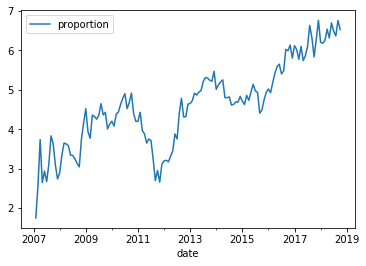

In [12]:
df_plot = comments_by_posts.select('mp.date', 'proportion').toPandas()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot = df_plot.set_index('date')

ax = df_plot.plot()

## Salvando RAW

In [ ]:
data \
    .repartition(2) \
    .write \
    .partitionBy('year', 'month') \
    .mode('overwrite') \
    .parquet('gs://data-fest-proc/zones/raw_zone/hackernews.parquet')